# 제 4고지 신경망 만들기

##### STEP37. 텐서를 다루다

In [1]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
c = Variable(np.array([[10, 20, 30], [40, 50, 60]]))
t = x + c
y = F.sum(t)
print(y)

variable(231)


In [2]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sin(x)
print(y)

variable([[ 0.84147098  0.90929743  0.14112001]
          [-0.7568025  -0.95892427 -0.2794155 ]])


In [3]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
c = Variable(np.array([[10, 20, 30], [40, 50, 60]]))
y = x + c
print(y)

variable([[11 22 33]
          [44 55 66]])


In [4]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
c = Variable(np.array([[10, 20, 30], [40, 50, 60]]))
t = x + c
y = F.sum(t)
print(y)

variable(231)


In [5]:
y.backward(retain_grad=True)   # 미분값 유지
print(y.grad)
print(t.grad)
print(x.grad)
print(c.grad)

variable(1)
variable([[1 1 1]
          [1 1 1]])
variable([[1 1 1]
          [1 1 1]])
variable([[1 1 1]
          [1 1 1]])


##### STEP38. 형상 변환 함수

In [6]:
x = np.array([[1, 2, 3], [4, 5, 6]])
y = np.reshape(x, 6)
print(y)

[1 2 3 4 5 6]


In [7]:
from dezero import Function

class Reshape(Function):
    def __init__(self, shape):
        self.shape = shape

    def forward(self, x):
        self.x_shape = x.shape # 핵심
        y = x.reshape(self.shape)
        return y
    
    def backward(self, gy):
        return reshape(gy, self.x_shape)

In [8]:
from dezero.core import as_variable

def reshape(x, shape):
    if x.shape == shape:
        return as_variable(x)
    return Reshape(shape)(x)

In [9]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.reshape(x, (6,))
y.backward(retain_grad=True)
print(x.grad)

variable([[1 1 1]
          [1 1 1]])


In [10]:
x = np.random.rand(1, 2, 3)

y = x.reshape((2, 3)) # 튜플로 받기
y = x.reshape([2, 3]) # 리스트로 받기
y = x.reshape(2, 3) # 인수로 그대로 ( 풀어서 ) 받기

In [11]:
import dezero

class Variable:
    __array_priority__ = 200

    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data # 변수의 데이터를 입력 데이터로 설정
        self.name = name # 변수 이름 저장
        self.grad = None # 미분값 저장
        self.creator = None # 연산을 나타내는 객체
        self.generation = 0 # 세대 수 기록

    @property
    def shape(self): # 다차원 배열의 형상
        return self.data.shape

    @property
    def ndim(self): # 차원 수
        return self.data.ndim

    @property
    def size(self): # 원소 수
        return self.data.size

    @property
    def dtype(self): # 데이터 타입
        return self.data.dtype

    def __len__(self): # 객체 수
        return len(self.data)

    def __repr__(self): # 출력 설정
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        # 세대를 기록함 ( 부모 세대 + 1)
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    # retain_grad=False : 중간  변수의 미분값을모두 None으로 재설정
    def backward(self, retain_grad=False, create_graph=False):
        # y.grad = np.array(1.0) 생략을 위한 if문
        if self.grad is None:
            """ Variable 인스턴스 참조 """
            self.grad = Variable(np.ones_like(self.data))

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()# 함수를 가져온다.
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys) # 함수 f의 역전파 호출 ( 리스트 언팩 )

            with using_config('enable_backprop', create_graph):
                """ 메인 backward """
                gxs = f.backward(*gys)
                
                # gxs가 튜플이 아니라면 튜플로 변환
                if not isinstance(gxs, tuple):
                    gxs = (gxs,)

                # 역전파로 전파되는 미분값을 Variable인스턴스 변수 grad에 저장
                for x, gx in zip(f.inputs, gxs):
                    if x.grad is None:
                        x.grad = gx
                    else:
                        x.grad = x.grad + gx

                    if x.creator is not None:
                        add_func(x.creator)

            # 중간 미분값 없앰
            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref <- 약한 참조

    def reshape(self, *shape):
        if len(shape) == 1 and isinstance(shape[0], (tuple, list)):
            shape = shape[0]
        return dezero.functions.reshape(self, shape)

In [12]:
from dezero.core import Variable

x = Variable(np.random.randn(1, 2, 3))
y = x.reshape((2, 3))
y = x.reshape(2, 3)

In [13]:
x = np.array([[1, 2, 3], [4, 5, 6]])
y = np.transpose(x)
print(y)

[[1 4]
 [2 5]
 [3 6]]


In [14]:
class Transpose(Function):
    def forward(self, x):
        y = np.transpose(x)
        return y
    
    def backward(self, gy):
        gx = transpose(gy)
        return gx
    
def transpose(x):
    return Transpose()(x)

In [15]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.transpose(x)
y.backward()
print(x.grad)

variable([[1 1 1]
          [1 1 1]])


In [16]:
import dezero

class Variable:
    __array_priority__ = 200

    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data # 변수의 데이터를 입력 데이터로 설정
        self.name = name # 변수 이름 저장
        self.grad = None # 미분값 저장
        self.creator = None # 연산을 나타내는 객체
        self.generation = 0 # 세대 수 기록

    @property
    def shape(self): # 다차원 배열의 형상
        return self.data.shape

    @property
    def ndim(self): # 차원 수
        return self.data.ndim

    @property
    def size(self): # 원소 수
        return self.data.size

    @property
    def dtype(self): # 데이터 타입
        return self.data.dtype

    def __len__(self): # 객체 수
        return len(self.data)

    def __repr__(self): # 출력 설정
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        # 세대를 기록함 ( 부모 세대 + 1)
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    # retain_grad=False : 중간  변수의 미분값을모두 None으로 재설정
    def backward(self, retain_grad=False, create_graph=False):
        # y.grad = np.array(1.0) 생략을 위한 if문
        if self.grad is None:
            """ Variable 인스턴스 참조 """
            self.grad = Variable(np.ones_like(self.data))

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()# 함수를 가져온다.
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys) # 함수 f의 역전파 호출 ( 리스트 언팩 )

            with using_config('enable_backprop', create_graph):
                """ 메인 backward """
                gxs = f.backward(*gys)
                
                # gxs가 튜플이 아니라면 튜플로 변환
                if not isinstance(gxs, tuple):
                    gxs = (gxs,)

                # 역전파로 전파되는 미분값을 Variable인스턴스 변수 grad에 저장
                for x, gx in zip(f.inputs, gxs):
                    if x.grad is None:
                        x.grad = gx
                    else:
                        x.grad = x.grad + gx

                    if x.creator is not None:
                        add_func(x.creator)

            # 중간 미분값 없앰
            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref <- 약한 참조

    def reshape(self, *shape):
        if len(shape) == 1 and isinstance(shape[0], (tuple, list)):
            shape = shape[0]
        return dezero.functions.reshape(self, shape)
    
    def transpose(self):
        return dezero.functions.transpose(self)
    
    @property
    def T(self):
        return dezero.functions.transpose(self)

In [17]:
from dezero.core import Variable

x = Variable(np.random.rand(2, 3))
y = x.transpose()
y = x.T
print(y)

variable([[0.74112545 0.54285673]
          [0.4346437  0.11963681]
          [0.72927371 0.40421601]])


In [18]:
A, B, C, D = 1, 2, 3, 4
x = np.random.rand(A, B, C, D)
y = x.transpose(1, 0, 3, 2)

##### STEP39. 합계 함수

In [19]:
class Sum(Function):
    def forward(self, x):
        self.x_shape = x.shape
        y = x.sum()
        return y
    
    def backward(self, gy):
        gx = broadcast_to(gy, self.x_shape)
        return gx
    
def sum(x):
    return Sum()(x)

In [20]:
x = Variable(np.array([1, 2, 3, 4, 5, 6]))
y = F.sum(x)
y.backward()
print(y)
print(x.grad)

variable(21)
variable([1 1 1 1 1 1])


In [21]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sum(x)
y.backward()
print(y)
print(x.grad)

variable(21)
variable([[1 1 1]
          [1 1 1]])


In [22]:
x = np.array([[1, 2, 3], [4, 5, 6]])
y = np.sum(x, axis=0)
print(y)
print(x.shape, ' -> ', y.shape)

[5 7 9]
(2, 3)  ->  (3,)


In [23]:
x = np.array([[1, 2, 3], [4, 5, 6]])
y = np.sum(x, keepdims=True)
print(y)
print(y.shape)

[[21]]
(1, 1)


In [24]:
class Sum(Function):
    def __init__(self, axis, keepdims):
        self.axis = axis
        self.keepdims = keepdims

    def forward(self, x):
        self.x_shape = x.shape
        y = x.sum(axis=self.axis, keepdims=self.keepdims)
        return y
    
    def backward(self, gy):
        gy = utils.reshape_sum_sum_backward(
            gy, self.x_shape, self.axis, self.keepdims)
        gx = broadcast_to(gy.self.x_shape)

def sum(x, axis=None, keepdims=False):
    return Sum(axis, keepdims)(x)

In [25]:
import dezero

class Variable:
    __array_priority__ = 200

    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data # 변수의 데이터를 입력 데이터로 설정
        self.name = name # 변수 이름 저장
        self.grad = None # 미분값 저장
        self.creator = None # 연산을 나타내는 객체
        self.generation = 0 # 세대 수 기록

    @property
    def shape(self): # 다차원 배열의 형상
        return self.data.shape

    @property
    def ndim(self): # 차원 수
        return self.data.ndim

    @property
    def size(self): # 원소 수
        return self.data.size

    @property
    def dtype(self): # 데이터 타입
        return self.data.dtype

    def __len__(self): # 객체 수
        return len(self.data)

    def __repr__(self): # 출력 설정
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        # 세대를 기록함 ( 부모 세대 + 1)
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    # retain_grad=False : 중간  변수의 미분값을모두 None으로 재설정
    def backward(self, retain_grad=False, create_graph=False):
        # y.grad = np.array(1.0) 생략을 위한 if문
        if self.grad is None:
            """ Variable 인스턴스 참조 """
            self.grad = Variable(np.ones_like(self.data))

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()# 함수를 가져온다.
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys) # 함수 f의 역전파 호출 ( 리스트 언팩 )

            with using_config('enable_backprop', create_graph):
                """ 메인 backward """
                gxs = f.backward(*gys)
                
                # gxs가 튜플이 아니라면 튜플로 변환
                if not isinstance(gxs, tuple):
                    gxs = (gxs,)

                # 역전파로 전파되는 미분값을 Variable인스턴스 변수 grad에 저장
                for x, gx in zip(f.inputs, gxs):
                    if x.grad is None:
                        x.grad = gx
                    else:
                        x.grad = x.grad + gx

                    if x.creator is not None:
                        add_func(x.creator)

            # 중간 미분값 없앰
            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref <- 약한 참조

    def reshape(self, *shape):
        if len(shape) == 1 and isinstance(shape[0], (tuple, list)):
            shape = shape[0]
        return dezero.functions.reshape(self, shape)
    
    def transpose(self):
        return dezero.functions.transpose(self)
    
    @property
    def T(self):
        return dezero.functions.transpose(self)
    
    def sum(self, axis=None, keepdims=False):
        return dezero.functions.sum(self, axis, keepdims)

In [26]:
from dezero.core import Variable

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sum(x, axis=0)
y.backward()
print(y)
print(x.grad)

x = Variable(np.random.randn(2, 3, 4, 5))
y = x.sum(keepdims=True)
print(y.shape)

variable([5 7 9])
variable([[1 1 1]
          [1 1 1]])
(1, 1, 1, 1)


##### STEP40. 브로드캐스트 함수

In [27]:
x = np.array([1, 2, 3])
y = np.broadcast_to(x, (2, 3))
print(y)

[[1 2 3]
 [1 2 3]]


In [28]:
from dezero.utils import sum_to

x = np.array([[1, 2, 3], [4, 5, 6]])
y = sum_to(x, (1, 3))
print(y)

y = sum_to(x, (2, 1))
print(y)

[[5 7 9]]
[[ 6]
 [15]]


In [29]:
class BroadcastTo(Function):
    def __init__(self, shape):
        self.shape = shape

    def forward(self, x):
        self.x_shape = x.shape
        y = np.broadcast_to(x, self.shape)
        return y
    
    def backward(self, gy):
        gx = sum_to(gy, self.x_shape)
        return gx
    
def broadcast_to(x, shape):
    if x.shape == shape:
        return as_variable(x)
    return BroadcastTo(shape)(x)

In [30]:
from dezero import utils

class SumTo(Function):
    def __init__(self, shape):
        self.shape = shape

    def forward(self, x):
        self.x_shape = x.shape
        y = utils.sum_to(x, self.shape)
        return y
    
    def backward(self, gy):
        gx = broadcast_to(gy, self.x_shape)
        return gx
    
def sum_to(x, shape):
    if x.shape == shape:
        return as_variable(x)
    return SumTo(shape)(x)

In [31]:
x0 = np.array([1, 2, 3])
x1 = np.array([10])
y = x0 + x1
print(y)

[11 12 13]


In [32]:
x0 = Variable(np.array([1, 2, 3]))
x1 = Variable(np.array([10]))
y = x0 + x1
print(y)

variable([11 12 13])


In [33]:
class Add(Function):
    def forward(self, x0, x1):
        self.x0_shape, self.x1_shape = x0.shape, x1.shape
        y = x0 + x1
        return y
    
    def backward(self, gy):
        gx0, gx1 = gy, gy
        if self.x0_shape != self.x1_shape:
            gx0 = dezero.functions.sum_to(gx0, self.x0_shape)
            gx1 = dezero.functions.sum_to(gx1, self.x1_shape)
        return gy, gy

In [34]:
from dezero import Variable

x0 = Variable(np.array([1, 2, 3]))
x1 = Variable(np.array([10]))
y = x0 + x1
print(y)

y.backward()
print(x1.grad)

variable([11 12 13])
variable([3])


##### STEP41. 행렬의 곱

In [35]:
# 벡터의 내적
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
c = np.dot(a, b)
print(c)

# 행렬의 곱
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])
c = np.dot(a, b)
print(c)

32
[[19 22]
 [43 50]]


In [36]:
class MatMul(Function):
    def forward(self, x, W):
        y = x.dot(W)
        return y
    
    def backward(self, gy):
        x, W = self.inputs
        gx = matmul(gy, W.T)
        gW = matmul(x.T, gy)
        return gx, gW
    
def matmul(x, W):
    return MatMul()(x, W)

In [37]:
x = Variable(np.random.randn(2, 3))
W = Variable(np.random.randn(3, 4))
y = F.matmul(x, W)
y.backward()

print(x.grad.shape)
print(W.grad.shape)

(2, 3)
(3, 4)


##### STEP42. 선형 회귀

In [38]:
np.random.seed(0)
x = np.random.rand(100, 1)
y = 5 + 2 * x + np.random.rand(100, 1)

In [39]:
W = Variable(np.zeros((1, 1)))
b = Variable(np.zeros(1))

def predict(x):
    y = F.matmul(x, W) + b
    return y

In [40]:
def mean_squared_error(x0, x1):
    diff = x0 - x1
    return F.sum(diff ** 2) / len(diff)

In [41]:
import matplotlib.pyplot as plt
import dezero.functions as F

# Generate toy dataset
np.random.seed(0)
x = np.random.rand(100, 1)
y = 5 + 2 * x + np.random.rand(100, 1)
x, y = Variable(x), Variable(y)

W = Variable(np.zeros((1, 1)))
b = Variable(np.zeros(1))

In [42]:
def predict(x):
    y = F.matmul(x, W) + b
    return y

In [43]:
def mean_squared_error(x0, x1):
    diff = x0 - x1
    return F.sum(diff ** 2) / len(diff)

In [44]:
lr = 0.1
iters = 100

for i in range(iters):
    y_pred = predict(x)
    loss = mean_squared_error(y, y_pred)

    W.cleargrad()
    b.cleargrad()
    loss.backward()

    W.data -= lr * W.grad.data
    b.data -= lr * b.grad.data
    print(W, b, loss)

variable([[0.64433458]]) variable([1.29473389]) variable(42.296340129442335)
variable([[1.12672345]]) variable([2.26959351]) variable(23.97380754378544)
variable([[1.48734571]]) variable([3.00386712]) variable(13.609686745040522)
variable([[1.75641886]]) variable([3.557186]) variable(7.747049961219976)
variable([[1.95666851]]) variable([3.97439789]) variable(4.43057410592155)
variable([[2.10518573]]) variable([4.28923203]) variable(2.554280381353593)
variable([[2.21482401]]) variable([4.52705574]) variable(1.492599869047195)
variable([[2.29524981]]) variable([4.70694745]) variable(0.8916952181756939)
variable([[2.35373273]]) variable([4.84325585]) variable(0.5514270962227455)
variable([[2.39573972]]) variable([4.9467725]) variable(0.3585915308319281)
variable([[2.425382]]) variable([5.02561369]) variable(0.24915731977561134)
variable([[2.44575118]]) variable([5.08588371]) variable(0.1869065876539789)
variable([[2.45917205]]) variable([5.13217364]) variable(0.1513533629631488)
variable(

In [45]:
class MeanSquaredError(Function):
    def forward(self, x0, x1):
        diff = x0 - x1
        y = (diff ** 2).sum() / len(diff)
        return y
    
    def backward(self, gy):
        x0, x1 = self.inputs
        diff = x0 - x1
        gx0 = gy * diff * (2. / len(diff))
        gx1 = -gx0
        return gx0, gx1
    
def mean_squared_error(x0, x1):
    return MeanSquaredError()(x0, x1)

##### STEP43. 신경망

In [46]:
def linear_simple(x, W, b=None):
    x = F.matmul(x, W)
    if b is None:
        return x
    y = x + b
    t.data = None # t의 데이터 삭제
    return y

In [47]:
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

In [48]:
def sigmoid_simple(x):
    x = as_variable(x)
    y = 1 / (1 + exp(-x))
    return y

In [49]:
from dezero import Variable
import dezero.functions as F

# 데이터셋
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

# 가중치 초기화
I, H, O = 1, 10, 1
W1 = Variable(0.01 * np.random.randn(I, H))
b1 = Variable(np.zeros(H))
W2 = Variable(0.01 * np.random.randn(H, O))
b2 = Variable(np.zeros(O))

# 신경망 추론
def predict(x):
    y = F.linear(x, W1, b1)
    y = F.sigmoid(y)
    y = F.linear(y, W2, b2)
    return y

lr = 0.2
iters = 10000

# 신경망 학습
for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    W1.cleargrad()
    b1.cleargrad()
    W2.cleargrad()
    b2.cleargrad()
    loss.backward()

    W1.data -= lr * W1.grad.data
    b1.data -= lr * b1.grad.data
    W2.data -= lr * W2.grad.data
    b2.data -= lr * b2.grad.data
    if i % 1000 == 0:
        print(loss) # 1000회마다 출력

variable(0.8473695850105871)
variable(0.2514286285183607)
variable(0.24759485466749878)
variable(0.23786120447054832)
variable(0.21222231333102953)
variable(0.16742181117834223)
variable(0.0968193261999272)
variable(0.07849528290602335)
variable(0.07749729552991157)
variable(0.07722132399559317)


##### STEP44. 매개변수를 모아두는 계층

In [50]:
class Parameter(Variable):
    pass

In [51]:
from dezero import Variable, Parameter

x = Variable(np.array(1.0))
p = Parameter(np.array(2.0))
y = x * p

print(isinstance(p, Parameter))
print(isinstance(x, Parameter))
print(isinstance(y, Parameter))

True
False
False


In [52]:
class Layer:
    def __init__(self):
        self._params = set()

    def __setattr__(self, name, value):
        if isinstance(value, (Parameter, Layer)):
            self._params.add(name)
        super().__setattr__(name, value)

In [53]:
layer = Layer()

layer.p1 = Parameter(np.array(1))
layer.p2 = Parameter(np.array(2))
layer.p3 = Variable(np.array(3))
layer.p4 = 'test'

print(layer._params)
print('-----------------')

for name in layer._params:
    print(name, layer.__dict__[name])

{'p1', 'p2'}
-----------------
p1 variable(1)
p2 variable(2)


In [54]:
class Layer:
    def __init__(self):
        self._params = set()

    def __setattr__(self, name, value):
        if isinstance(value, (Parameter, Layer)):
            self._params.add(name)
        super().__setattr__(name, value)

    def __call__(self, *inputs):
        outputs = self.forward(*inputs)
        if not isinstance(outputs, tuple):
            outputs = (outputs,)
        self.inputs = [x.data for x in inputs]
        self.outputs = [weakref.ref(y) for y in outputs]
        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, inputs):
        raise NotImplementedError()
    
    def params(self):
        for name in self._params:
            obj = self.__dict__[name]

    def cleargrads(self):
        for param in self.params():
            param.cleargrad()

In [55]:
class Layer(Layer):
    def __init__(self, in_size, out_size, nobias=False, dtype=np.float32):
        super().__init__()
        
        I, O = in_size, out_size
        W_data = np.random.randn(I, O).astype(dtype) * np.sqrt(1 / I)
        self.W = Parameter(W_data, name='W')
        if nobias:
            self.b = None
        else:
            self.b = Parameter(np.zeros(O, dtype=dtype), name='b')

    def forward(self, x):
        y = F.linear(x, self.W, self.b)
        return y

In [56]:
class Layer(Layer):
    def __init__(self, in_size, out_size, nobias=False, dtype=np.float32):
        super().__init__()
        self.in_size = in_size
        self.out_size = out_size
        self.dtype = dtype

        self.W = Parameter(None, name='W')
        if self.in_size is not None:
            self._init_W()

        if nobias:
            self.b = None
        else:
            self.b = Parameter(np.zeros(out_size, dtype=dtype), name='b')

    def _init_W(self):
        I, O = self.in_size, self.out_size
        W_data = np.random.randn(I, O).astype(self.dtype) * np.sqrt(1 / I)
        self.W.data = W_data

    def forward(self, x):
        if self.W.data is None:
            self.in_size = x.shape[1]
            xp = cuda.get_array_module(x)
            self._init_W(xp)
        y = F.linear(x, self.W, self.b)
        return y

In [57]:
import os, sys
import numpy as np
import dezero.functions as F
import dezero.layers as L

# 데이터셋
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

l1 = L.Linear(10) # 출력 크기 지정
l2 = L.Linear(1)

def predict(x):
    y = l1(x)
    y = F.sigmoid(y)
    y = l2(y)
    return y

lr = 0.2
iters = 10000

for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    l1.cleargrads()
    l2.cleargrads()
    loss.backward()

    for l in [l1, l2]:
        for p in l.params():
            p.data -= lr * p.grad.data

    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649353)
variable(0.07888166506355147)
variable(0.07655073683421637)
variable(0.0763780308623822)
variable(0.07618764131185572)


##### STEP45. 계층을 모아두는 계층

In [58]:
class Layer:
    def __init__(self):
        self._params = set()

    def __setattr__(self, name, value):
        if isinstance(value, (Parameter, Layer)): # Layer도 추가
            self._params.add(name)
        super().__setattr__(name, value)

    def params(self):
        for name in self._params:
            obj = self.__dict__[name]

            if isinstance(obj, Layer): # Layer에서 매개변수 꺼내기
                yield from obj.params()
            else:
                yield obj

In [59]:
import dezero.layers as L
import dezero.functions as F
from dezero import Layer

model = Layer()
model.l1 = L.Linear(5) # 출력 크기 지정
model.l2 = L.Linear(3)

# 추론을 수행하는 함수
def predict(model, x):
    y = model.l1(x)
    y = F.sigmoid(y)
    y = model.l2(y)
    return y

# 모든 매개변수에 접근
for p in model.params():
    print(p)

# 모든 매개변수의 기울기를 재설정
model.cleargrads()

variable(None)
variable([0. 0. 0.])
variable(None)
variable([0. 0. 0. 0. 0.])


In [60]:
class TwoLayerNet(Layer):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y

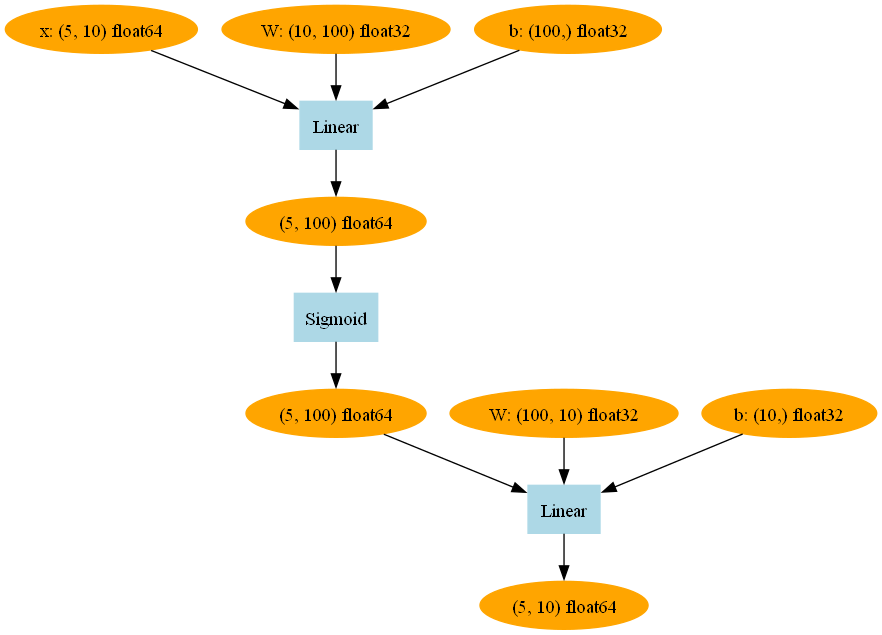

In [61]:
from dezero import Variable, Model
import dezero.layers as L
import dezero.functions as F

class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y
    
x = Variable(np.random.randn(5, 10), name='x')
model = TwoLayerNet(100, 10)
model.plot(x)

In [62]:
import numpy as np
from dezero import Variable, Model
import dezero.layers as L
import dezero.functions as F

# 데이터셋
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

# 하이퍼파라미터 설정
lr = 0.2
max_iter = 10000
hidden_size = 10

# 모델 정의
class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y
    
model = TwoLayerNet(hidden_size, 1)

# 학습 시작
for i in range(iters):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()
    loss.backward()

    for p in model.params():
        p.data -= lr * p.grad.data

    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649353)
variable(0.07888166506355147)
variable(0.07655073683421637)
variable(0.0763780308623822)
variable(0.07618764131185572)


In [63]:
import dezero.functions as F
import dezero.layers as L

class MLP(Model):
    def __init__(self, fc_output_sizes, activation=F.sigmoid):
        super().__init__()
        self.activation = activation
        self.layers = []

        for i, out_size in enumerate(fc_output_sizes):
            layer = L.Linear(out_size)
            setattr(self, 'l' + str(i), layer)
            self.layers.append(layer)

    def forward(self, x):
        for l in self.layers[:-1]:
            x = self.activation(l(x))
        return self.layers[-1](x)

In [64]:
model = MLP((10, 1)) # 2층
model = MLP((10, 20, 30, 40, 1)) # 5층

##### STEP46. Optimizer로 수행하는 매개변수 갱신

In [65]:
class Optimizer:
	def __init__(self):
		self.target = None
		self.hooks = []
		
	def setup(self, target):
		self.target = target
		return self
		
	def update(self):
		# None 이외의 매개변수를 리스트에 모아둠
		params = [p for p in self.target.params() if p.rad is not None]
		
        # 전처리(옵션)
		for f in self.hooks:
		    f(params)
		
        # 매개변수 갱신
		for param in params:
			self.update_one(param)
			
	def update_one(self, param):
		raise NotImplementedError()
		
	def add_hook(self, f):
		self.hooks.append(f)

In [66]:
class SGD(Optimizer):
	def __init__(self, lr = 0.01):
		super().__init__()
		self.lr = lr
		
	def update_one(self, param):
		param.data -= self.lr * param.grad.data

In [67]:
import numpy as np
from dezero import Variable
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
max_iter = 10000
hidden_size = 10

model = MLP((hidden_size, 1))
optimizer = optimizers.SGD(lr)
optimizer.setup(model)

# 또는 다음처럼 한 줄로 합칠 수 있다.
# optimizer = optimizers.SGD(lr).setup(model)

for i in range(max_iter):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()
    loss.backward()

    optimizer.update()

    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649353)
variable(0.07888166506355147)
variable(0.07655073683421637)
variable(0.0763780308623822)
variable(0.07618764131185572)


In [68]:
class MomentumSGD(Optimizer):
    def __init__(self, lr=0.01, momentum=0.9):
        super().__init__()
        self.lr = lr
        self.momentum = momentum
        self.vs = {}

    def update_one(self, param):
        v_key = id(param)
        if v_key not in self.vs:
            xp = cuda.get_array_module(param.data)
            self.vs[v_key] = np.zeros_like(param.data)

        v = self.vs[v_key]
        v *= self.momentum
        v -= self.lr * param.grad.data
        param.data += v

##### STEP47. 소프트맥스 함수와 교차 엔트로피 오차

In [69]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.get_item(x, 1)
print(y)

variable([4 5 6])


In [70]:
y.backward()
print(x.grad)

variable([[0 0 0]
          [1 1 1]])


In [71]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
indices = np.array([0, 0, 1])
y = F.get_item(x, indices)
print(y)

variable([[1 2 3]
          [1 2 3]
          [4 5 6]])


In [72]:
Variable.__getitem__ = F.get_item

y = x[1]
print(y)

y = x[:, 2]
print(y)

variable([4 5 6])
variable([3 6])


In [73]:
from dezero.models import MLP
model = MLP((10, 3))

In [74]:
x = np.array([[0.2, -0.4]])
y = model(x)
print(y)

variable([[0.25337848 0.30853735 0.38821423]])


In [75]:
from dezero import Variable, as_variable
import dezero.functions as F

def softmax1d(x):
    x = as_variable(x)
    y = F.exp(x)
    sum_y = F.sum(y)
    return y / sum_y

In [76]:
model = MLP((10, 3))
x = np.array([[0.2, -0.4]])
y = model(x)
p = softmax1d(y)
print(y)
print(p)

variable([[-0.51222398 -0.48154886 -0.19620913]])
variable([[0.29387554 0.30302989 0.40309457]])


In [77]:
def softmax_simple(x, axis=1):
    x = as_variable(x)
    y = exp(x)
    sum_y = sum(y, axis=axis, keepdims=True)
    return y / sum_y

In [78]:
def softmax_cross_entropy_simple(x, t):
    x, t = as_variable(x), as_variable(t)
    N = x.shape[0]
    p = softmax(x)
    p = clip(p, 1e-15, 1.0)  # To avoid log(0)
    log_p = log(p)
    tlog_p = log_p[np.arange(N), t.data]
    y = -1 * sum(tlog_p) / N
    return y

In [79]:
x = np.array([[0.2, -0.4], [0.3, 0.5], [1.3, -3.2], [2.1, 0.3]])
t = np.array([2, 0, 1, 0])
y = model(x)
loss = F.softmax_cross_entropy_simple(y, t)
print(loss)

variable(1.005250977723018)


##### STEP48. 다중 클래스 분류

In [80]:
import dezero

x, t = dezero.datasets.get_spiral(train=True)
print(x.shape)
print(t.shape)

print(x[10], t[10])
print(x[110], t[110])

(300, 2)
(300,)
[-0.12995958 -0.00324155] 1
[ 0.3282343  -0.54941994] 0


In [81]:
import math
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP

# ( 1 ) Hyperparameters
max_epoch = 300
batch_size = 30
hidden_size = 10

# ( 2 ) 데이터 읽기 / 모델, 옵티마이저 생성
x, t = dezero.datasets.get_spiral(train=True)
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD().setup(model)

In [82]:
data_size = len(x)
max_iter = math.ceil(data_size / batch_size)

for epoch in range(max_epoch):
    # ( 3 ) Shuffle index for data
    index = np.random.permutation(data_size)
    sum_loss = 0

    for i in range(max_iter):
        # ( 4 ) 미니배치 생성
        batch_index = index[i * batch_size:(i + 1) * batch_size]
        batch_x = x[batch_index]
        batch_t = t[batch_index]

        # ( 5 ) 기울기 산출 / 매개변수 갱신
        y = model(batch_x)
        loss = F.softmax_cross_entropy_simple(y, batch_t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(batch_t)

    # ( 6 ) Print loss every epoch
    avg_loss = sum_loss / data_size
    print('epoch %d, loss %.2f' % (epoch + 1, avg_loss))

epoch 1, loss 1.16
epoch 2, loss 1.15
epoch 3, loss 1.15
epoch 4, loss 1.15
epoch 5, loss 1.15
epoch 6, loss 1.14
epoch 7, loss 1.14
epoch 8, loss 1.14
epoch 9, loss 1.14
epoch 10, loss 1.14
epoch 11, loss 1.13
epoch 12, loss 1.13
epoch 13, loss 1.13
epoch 14, loss 1.13
epoch 15, loss 1.13
epoch 16, loss 1.13
epoch 17, loss 1.13
epoch 18, loss 1.12
epoch 19, loss 1.12
epoch 20, loss 1.12
epoch 21, loss 1.12
epoch 22, loss 1.12
epoch 23, loss 1.12
epoch 24, loss 1.12
epoch 25, loss 1.11
epoch 26, loss 1.11
epoch 27, loss 1.11
epoch 28, loss 1.11
epoch 29, loss 1.11
epoch 30, loss 1.11
epoch 31, loss 1.11
epoch 32, loss 1.11
epoch 33, loss 1.10
epoch 34, loss 1.10
epoch 35, loss 1.10
epoch 36, loss 1.10
epoch 37, loss 1.10
epoch 38, loss 1.10
epoch 39, loss 1.10
epoch 40, loss 1.10
epoch 41, loss 1.10
epoch 42, loss 1.09
epoch 43, loss 1.09
epoch 44, loss 1.09
epoch 45, loss 1.09
epoch 46, loss 1.09
epoch 47, loss 1.09
epoch 48, loss 1.09
epoch 49, loss 1.09
epoch 50, loss 1.09
epoch 51,

##### STEP49. Dataset 클래스와 전처리

In [83]:
class Dataset:
    def __init__(self, train=True):
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        if self.transform is None:
            self.transform = lambda x: x
        if self.target_transform is None:
            self.target_transform = lambda x: x
        self.data = None
        self.label = None
        self.prepare()

    def __getitem__(self, index):
        assert np.isscalar(index)
        if self.label is None:
            return self.transform(self.data[index]), None
        else:
            return self.transform(self.data[index]), \
                self.target_transform(self.label[index])
        
    def __len__(self):
        return len(self.data)
    
    def prepare(self):
        pass

In [84]:
class Spiral(Dataset):
    def prepare(self):
        self.data, self.label = get_spiral(self.train)

In [85]:
import dezero.datasets as ds

train_set = ds.Spiral(train=True)
print(train_set[0])
print(len(train_set))

(array([-0.13981389, -0.00721657], dtype=float32), 1)
300


In [86]:
class BigData(Dataset):
    def __getitem__(self, index):
        x = np.load('data/{}.npy'.format(index))
        t = np.load('label/{}.npy'.format(index))
        return x, t
    
    def __len__():
        return 1000000

In [87]:
train_set = ds.Spiral()

batch_index = [0, 1, 2]
batch = [train_set[i] for i in batch_index]

x = np.array([example[0] for example in batch])
t = np.array([example[1] for example in batch])

print(x.shape)
print(t.shape)

(3, 2)
(3,)


In [88]:
max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

train_set = dezero.datasets.Spiral()
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

data_size = len(train_set)
max_iter = math.ceil(data_size / batch_size)

for epoch in range(max_epoch):
    index = np.random.permutation(data_size)
    sum_loss = 0

    for i in range(max_iter):
        # 미니배치 꺼내기
        batch = [train_set[i] for i in batch_index]
        batch_x = np.array([example[0] for example in batch])
        batch_t = np.array([example[1] for example in batch])

        y = model(batch_x)
        loss = F.softmax_cross_entropy_simple(y, batch_t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(batch_t)

    # 에포크마다 손실 출력
    avg_loss = sum_loss / data_size
    print('epoch %d, loss %.2f' % (epoch + 1, avg_loss))

epoch 1, loss 0.07
epoch 2, loss 0.06
epoch 3, loss 0.05
epoch 4, loss 0.04
epoch 5, loss 0.04
epoch 6, loss 0.03
epoch 7, loss 0.02
epoch 8, loss 0.02
epoch 9, loss 0.02
epoch 10, loss 0.01
epoch 11, loss 0.01
epoch 12, loss 0.01
epoch 13, loss 0.01
epoch 14, loss 0.01
epoch 15, loss 0.01
epoch 16, loss 0.00
epoch 17, loss 0.00
epoch 18, loss 0.00
epoch 19, loss 0.00
epoch 20, loss 0.00
epoch 21, loss 0.00
epoch 22, loss 0.00
epoch 23, loss 0.00
epoch 24, loss 0.00
epoch 25, loss 0.00
epoch 26, loss 0.00
epoch 27, loss 0.00
epoch 28, loss 0.00
epoch 29, loss 0.00
epoch 30, loss 0.00
epoch 31, loss 0.00
epoch 32, loss 0.00
epoch 33, loss 0.00
epoch 34, loss 0.00
epoch 35, loss 0.00
epoch 36, loss 0.00
epoch 37, loss 0.00
epoch 38, loss 0.00
epoch 39, loss 0.00
epoch 40, loss 0.00
epoch 41, loss 0.00
epoch 42, loss 0.00
epoch 43, loss 0.00
epoch 44, loss 0.00
epoch 45, loss 0.00
epoch 46, loss 0.00
epoch 47, loss 0.00
epoch 48, loss 0.00
epoch 49, loss 0.00
epoch 50, loss 0.00
epoch 51,

In [89]:
class Dataset:
    def __init__(self, train=True, transform=None, target_transform=None):
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        if self.transform is None:
            self.transform = lambda x: x
        if self.target_transform is None:
            self.target_transform = lambda x: x
        self.data = None
        self.label = None
        self.prepare()

    def __getitem__(self, index):
        assert np.isscalar(index)
        if self.label is None:
            return self.transform(self.data[index]), None
        else:
            return self.transform(self.data[index]), \
                self.target_transform(self.label[index])
        
    def __len__(self):
        return len(self.data)
    
    def prepare(self):
        pass

In [90]:
def f(x):
    y = x / 2.0
    return y

train_set = dezero.datasets.Spiral(transform=f)

In [91]:
from dezero import transforms

f = transforms.Normalize(mean=0.0, std=2.0)
train_set = dezero.datasets.Spiral(transform=f)

In [92]:
f = transforms.Compose([transforms.Normalize(mean=0.0, std=2.0), 
                        transforms.AsType(np.float64)])